# MODELOS DE REDES PARA DENGUE BUCARAMANGA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Bucaramanga_Lags.csv', encoding='latin-1', sep=";")
datos.columns

Index(['Municipio', 'Año', 'Semana_Epi', 'Casos_Dengue', 'Prom_Dia_Preci',
       'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3',
       'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6',
       'Total_Preci_Sem', 'Total_Preci_Sem_1', 'Total_Preci_Sem_2',
       'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5',
       'Total_Preci_Sem_6'],
      dtype='object')

In [3]:
# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_5',
                    'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
                    'Total_Preci_Sem', 'Total_Preci_Sem_5', 'Total_Preci_Sem_1',
                    'Total_Preci_Sem_2', 'Total_Preci_Sem_3', 'Total_Preci_Sem_4'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_6', 'Total_Preci_Sem_6'], dtype='object')

In [4]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_6     0
Total_Preci_Sem_6    0
dtype: int64

### División de los datos en set de entrenamiento y prueba

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [6]:
f_columns = ['Prom_Dia_Preci_6', 'Total_Preci_Sem_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [9]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [10]:
Buca_LSTM_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_LSTM_model_2.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Buca_LSTM_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Buca_LSTM_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_LSTM_model_8.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Buca_LSTM_model_2.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Buca_LSTM_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 8s - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0215 - val_mse: 0.0215 - 8s/epoch - 577ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0200 - val_mse: 0.0200 - 476ms/epoch - 34ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0056 - val_mse: 0.0056 - 413ms/epoch - 29ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0081 - val_mse: 0.0081 - 364ms/epoch - 26ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0113 - val_mse: 0.0113 - 367ms/epoch - 26ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0022 - val_mse: 0.0022 - 414ms/epoch - 30ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0088 - val_mse: 0.0088 - 372ms/epoch - 27ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0027 - val_mse: 0.0027 - 368ms/epoch - 26ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0046 - val_mse: 

# MODELO CNN

In [11]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [12]:
Buca_CNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_CNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Buca_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Buca_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Buca_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Buca_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Buca_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Buca_CNN_model_2.add(Dropout(0.5))
Buca_CNN_model_2.add(Flatten())
    
Buca_CNN_model_2.add(keras.layers.Dense(units=256, activation='linear'))
Buca_CNN_model_2.add(Dropout(0.5)) 


#CAPA DE SALIDA                 
Buca_CNN_model_2.add(Dense(1))


#COMPILACIÓN DEL MODELO
Buca_CNN_model_2.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_CNN_model_8.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Buca_CNN_model_2.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Buca_CNN_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 1s - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0108 - val_mse: 0.0108 - 1s/epoch - 87ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0021 - val_mse: 0.0021 - 163ms/epoch - 12ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0020 - val_mse: 0.0020 - 132ms/epoch - 9ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0010 - val_mse: 0.0010 - 140ms/epoch - 10ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0075 - mse: 0.0075 - val_loss: 8.9962e-04 - val_mse: 8.9962e-04 - 141ms/epoch - 10ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0023 - val_mse: 0.0023 - 96ms/epoch - 7ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0016 - val_mse: 0.0016 - 97ms/epoch - 7ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0014 - val_mse: 0.0014 - 100ms/epoch - 7ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0015 - val_mse:

# MODELO RNN

In [13]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [14]:
Buca_RNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_RNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Buca_RNN_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Buca_RNN_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_RNN_model_8.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Buca_RNN_model_2.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Buca_RNN_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 4s - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0032 - val_mse: 0.0032 - 4s/epoch - 298ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0087 - val_mse: 0.0087 - 200ms/epoch - 14ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0116 - val_mse: 0.0116 - 221ms/epoch - 16ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0087 - val_mse: 0.0087 - 200ms/epoch - 14ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0070 - val_mse: 0.0070 - 207ms/epoch - 15ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0084 - val_mse: 0.0084 - 212ms/epoch - 15ms/step


# MODELO GRU

In [15]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [16]:
Buca_GRU_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_GRU_model_2.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Buca_GRU_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Buca_GRU_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_GRU_model_8.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Buca_GRU_model_2.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Buca_GRU_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 13s - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0112 - val_mse: 0.0112 - 13s/epoch - 959ms/step
Epoch 2/100
14/14 - 1s - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0019 - val_mse: 0.0019 - 631ms/epoch - 45ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0046 - val_mse: 0.0046 - 447ms/epoch - 32ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0057 - val_mse: 0.0057 - 435ms/epoch - 31ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0022 - val_mse: 0.0022 - 468ms/epoch - 33ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0059 - val_mse: 0.0059 - 404ms/epoch - 29ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0077 - val_mse: 0.0077 - 460ms/epoch - 33ms/step


### Graficas de función de pérdida & RMSE

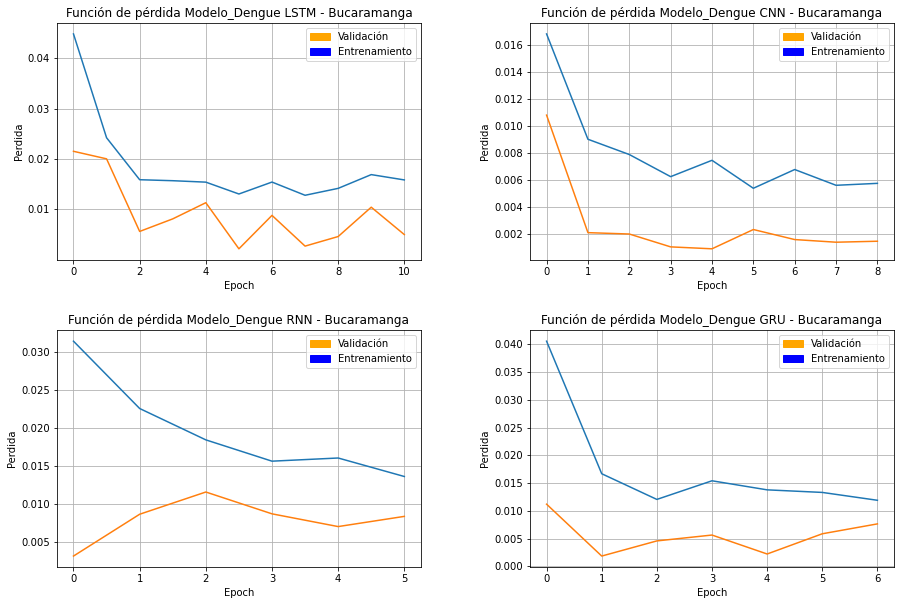

In [17]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue LSTM - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue CNN - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue RNN - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue GRU - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

6/6 [==============================] - 2s 9ms/step


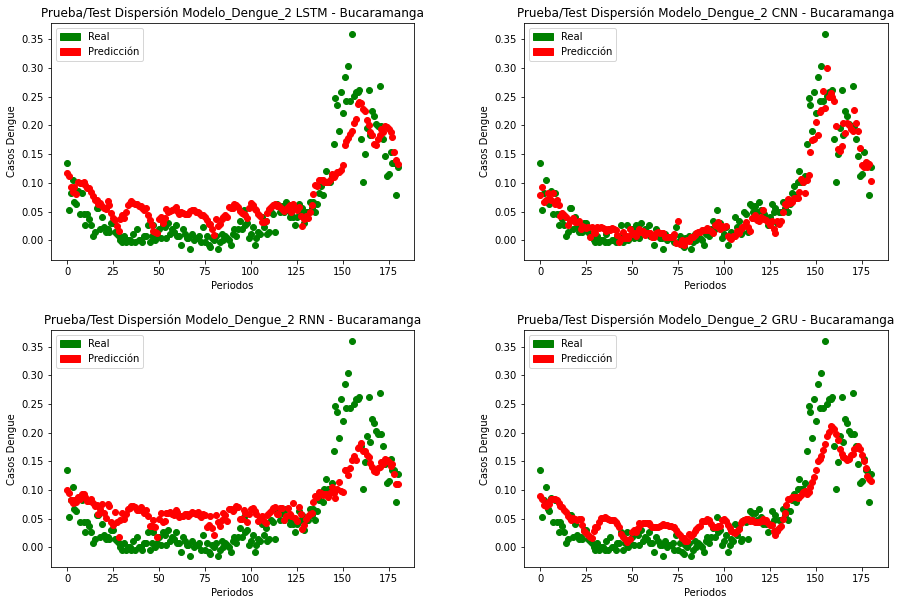

In [18]:
results_LSTM =Buca_LSTM_model_2.predict(X_test_LSTM)
results_CNN =Buca_CNN_model_2.predict(X_test_CNN)
results_RNN =Buca_RNN_model_2.predict(X_test_RNN)
results_GRU =Buca_GRU_model_2.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 LSTM - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 CNN - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 RNN - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 GRU - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [19]:
y_pred_LSTM = Buca_LSTM_model_2.predict(X_test_LSTM)
y_pred_CNN = Buca_CNN_model_2.predict(X_test_CNN)
y_pred_RNN = Buca_RNN_model_2.predict(X_test_RNN)
y_pred_GRU = Buca_GRU_model_2.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

6/6 [==============================] - 0s 8ms/step


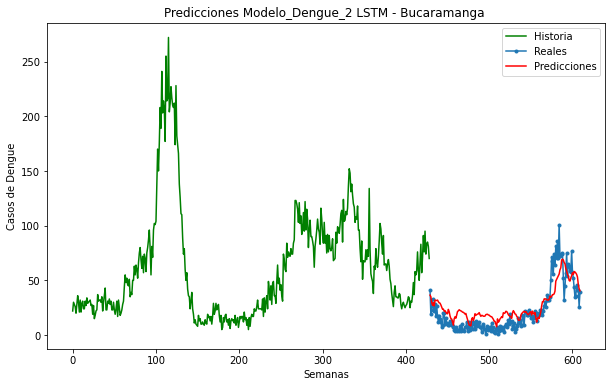

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 LSTM - Bucaramanga ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

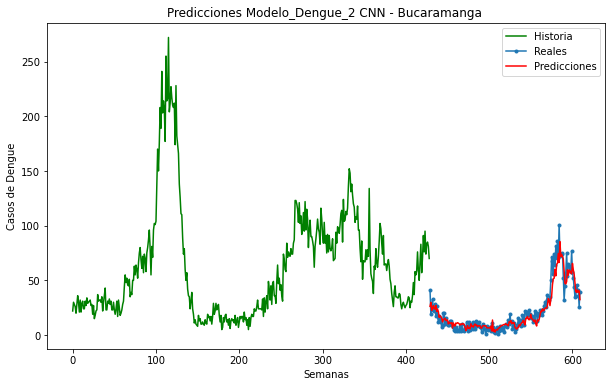

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 CNN - Bucaramanga ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

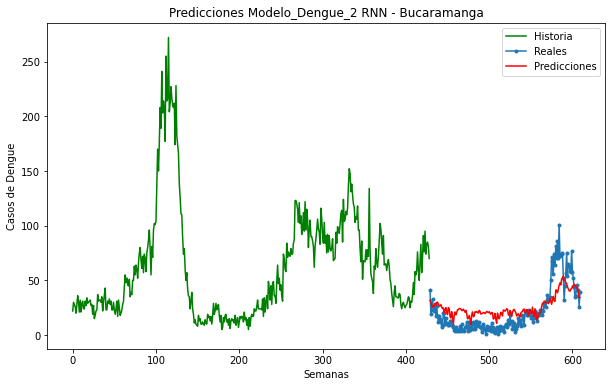

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 RNN - Bucaramanga')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

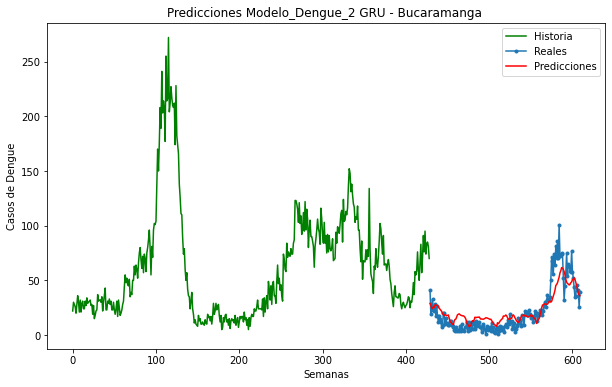

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 GRU - Bucaramanga ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

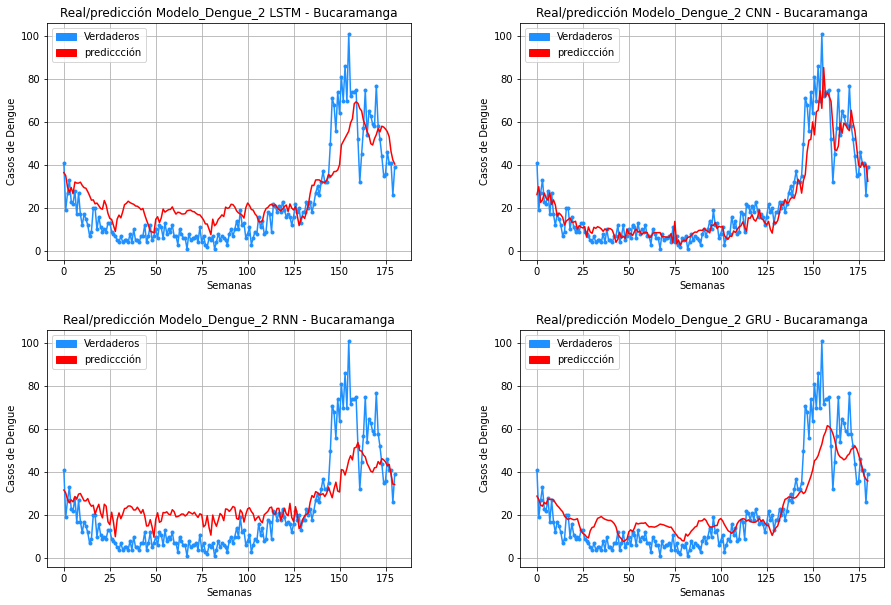

In [24]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue_2 LSTM - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue_2 CNN - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue_2 RNN - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue_2 GRU - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [25]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo_2 LSTM Dengue Bucaramanga : {}".format(score_LSTM))
print("RMSE Modelo_2  CNN Dengue  Bucaramanga  : {}".format(score_CNN))
print("RMSE Modelo_2  RNN Dengue  Bucaramanga : {}".format(score_RNN))
print("RMSE Modelo_2  GRU Dengue  Bucaramanga  : {}".format(score_GRU))

RMSE Modelo_2 LSTM Dengue Bucaramanga : 12.533191984584045
RMSE Modelo_2  CNN Dengue  Bucaramanga  : 8.008292694428423
RMSE Modelo_2  RNN Dengue  Bucaramanga : 15.011108761385914
RMSE Modelo_2  GRU Dengue  Bucaramanga  : 11.558924322581852


In [26]:
print("MSE Modelo_2  LSTM Dengue Bucaramanga  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo_2  CNN Dengue Bucaramanga   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo_2  RNN Dengue Bucaramanga   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo_2  GRU Dengue Bucaramanga   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo_2  LSTM Dengue Bucaramanga  =  157.08090132244175
MSE Modelo_2  CNN Dengue Bucaramanga   =  64.13275187963565
MSE Modelo_2  RNN Dengue Bucaramanga   =  225.33338624615695
MSE Modelo_2  GRU Dengue Bucaramanga   =  133.60873149517434


In [27]:
print("MAE Modelo_2  LSTM Dengue Bucaramanga = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo_2  CNN Dengue Bucaramanga  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo_2  RNN Dengue Bucaramanga  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo_2  GRU Dengue Bucaramanga = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo_2  LSTM Dengue Bucaramanga =  9.975422901343245
MAE Modelo_2  CNN Dengue Bucaramanga  =  5.37401346343657
MAE Modelo_2  RNN Dengue Bucaramanga  =  11.889013132337707
MAE Modelo_2  GRU Dengue Bucaramanga =  8.457924284329073


In [28]:
print("r2_score Modelo_2  LSTM Dengue Bucaramanga  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo_2  CNN Dengue Bucaramanga = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo_2  RNN Dengue Bucaramanga  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo_2  GRU Dengue Bucaramanga  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo_2  LSTM Dengue Bucaramanga  =  0.6582327598950979
r2_score Modelo_2  CNN Dengue Bucaramanga =  0.8604637901507628
r2_score Modelo_2  RNN Dengue Bucaramanga  =  0.5097330810270916
r2_score Modelo_2  GRU Dengue Bucaramanga  =  0.7093021046314885


In [29]:
print("explained_variance_score Modelo_2  LSTM Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo_2  CNN Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo_2  RNN Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo_2  GRU Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo_2  LSTM Dengue Bucaramanga  =  0.707544187583631
explained_variance_score Modelo_2  CNN Dengue Bucaramanga  =  0.8625700019936616
explained_variance_score Modelo_2  RNN Dengue Bucaramanga  =  0.5411094639659448
explained_variance_score Modelo_2  GRU Dengue Bucaramanga  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [30]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0      41.0     36.483406   -4.516594
1      19.0     35.061707   16.061707
2      27.0     29.666012    2.666012
3      33.0     27.238884   -5.761116
4      23.0     29.541485    6.541485
     Actuales  Predicciones  diferencia
176      46.0     55.464485    9.464485
177      41.0     53.136211   12.136211
178      41.0     46.284588    5.284588
179      26.0     42.351177   16.351177
180      39.0     40.460312    1.460312


In [31]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0      41.0     26.252459  -14.747541
1      19.0     29.895390   10.895390
2      27.0     22.588690   -4.411310
3      33.0     23.748360   -9.251640
4      23.0     26.946945    3.946945
     Actuales  Predicciones  diferencia
176      46.0     38.925755   -7.074245
177      41.0     41.283356    0.283356
178      41.0     39.089260   -1.910740
179      26.0     40.373077   14.373077
180      39.0     32.428886   -6.571114


In [32]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0      41.0     31.720743   -9.279257
1      19.0     30.361013   11.361013
2      27.0     27.285604    0.285604
3      33.0     25.744419   -7.255581
4      23.0     27.132874    4.132874
     Actuales  Predicciones  diferencia
176      46.0     42.942978   -3.057022
177      41.0     43.715801    2.715801
178      41.0     39.165520   -1.834480
179      26.0     34.470734    8.470734
180      39.0     34.325806   -4.674194


In [33]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0      41.0     28.899624  -12.100376
1      19.0     27.359417    8.359417
2      27.0     24.703640   -2.296360
3      33.0     24.209015   -8.790985
4      23.0     25.962500    2.962500
     Actuales  Predicciones  diferencia
176      46.0     45.151417   -0.848583
177      41.0     42.073071    1.073071
178      41.0     38.272446   -2.727554
179      26.0     36.737404   10.737404
180      39.0     35.949341   -3.050659
